<a href="https://colab.research.google.com/github/oopsys6/Time-Series-Forecasting-for-Covid19/blob/main/Ch4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. 데이터 모델링

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 4.1 데이터 다운로드


In [ ]:
!gdown --id 1QRKd4uiL8GKaH4DuuMsYRCS2gV0tAiwa

Downloading...
From: https://drive.google.com/uc?id=1QRKd4uiL8GKaH4DuuMsYRCS2gV0tAiwa
To: /content/korea_South_19-covid-Confirmed.csv
100% 4.17k/4.17k [00:00<00:00, 7.70MB/s]


## 4.2 데이터 탐색

In [ ]:
df = pd.read_csv('korea_South_19-covid-Confirmed.csv')
df.head()

,Country/Region,Province/State,Long,Lat,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20
0,"Korea, South",NaN,128,36,1,1,2,2,3,4,4,4,4,11,12,15,15,16,19,23,24,24,25,27,28,28,28,28,28,29,30,31,31,104,204,433,602,833,977,1261,...,24988,25035,25108,25199,25275,25333,25424,25543,25698,25775,25836,25955,26043,26146,26271,26385,26511,26635,26732,26807,26925,27050,27195,27284,27427,27553,27653,27799,27942,28133,28338,28546,28767,28975,29197,29427,29740,30083,30403,30733


In [ ]:
df = df.iloc[:, 4:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20
0,1,1,2,2,3,4,4,4,4,11,12,15,15,16,19,23,24,24,25,27,28,28,28,28,28,29,30,31,31,104,204,433,602,833,977,1261,1766,2337,3150,3736,...,24988,25035,25108,25199,25275,25333,25424,25543,25698,25775,25836,25955,26043,26146,26271,26385,26511,26635,26732,26807,26925,27050,27195,27284,27427,27553,27653,27799,27942,28133,28338,28546,28767,28975,29197,29427,29740,30083,30403,30733


In [ ]:
df.isnull().sum().sum()

0

In [ ]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22    1
2020-01-23    1
2020-01-24    2
2020-01-25    2
2020-01-26    3
dtype: int64

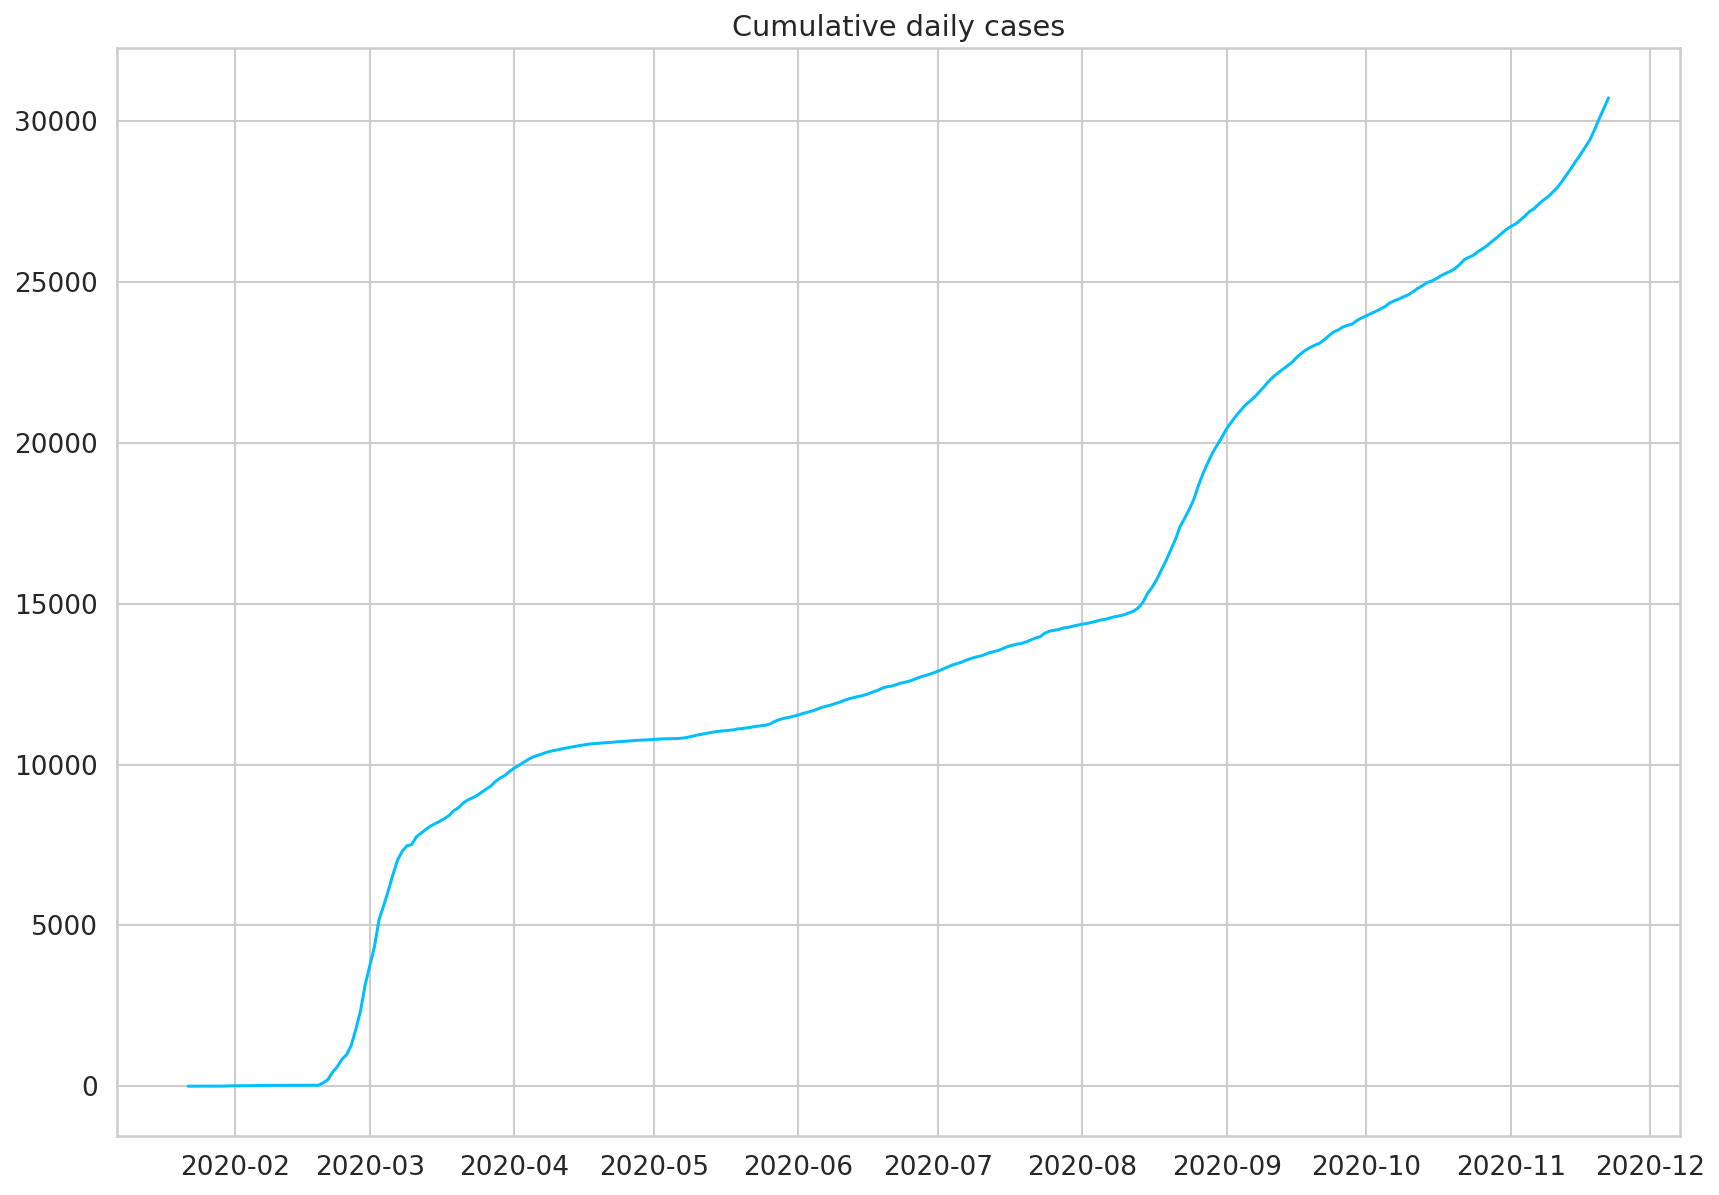

In [ ]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [ ]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    1
2020-01-23    0
2020-01-24    1
2020-01-25    0
2020-01-26    1
dtype: int64

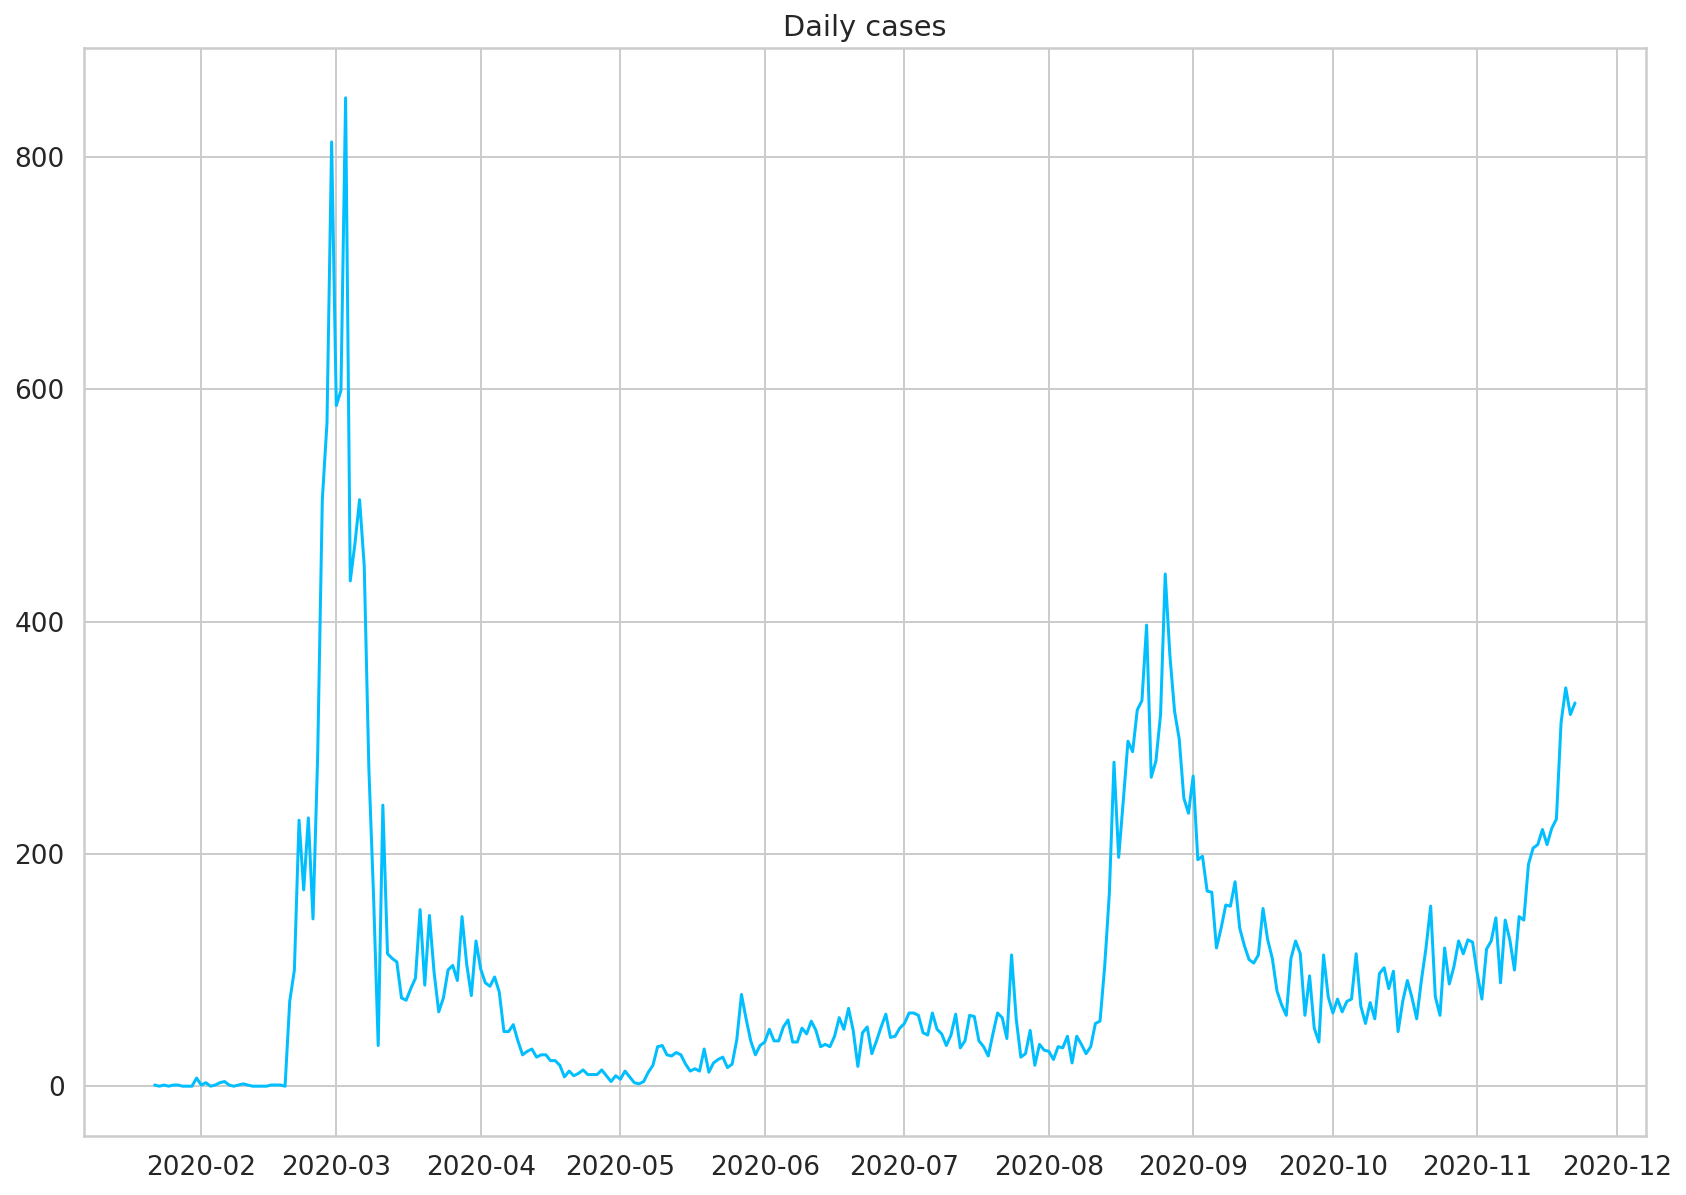

In [ ]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [ ]:
daily_cases.shape

(306,)

In [ ]:
test_data_size = 14
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
train_data.shape

(292,)

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
# X_train.shape
print(y_test)

tensor([[0.2444],
        [0.2597],
        [0.2444],
        [0.2609],
        [0.2703],
        [0.3678],
        [0.4031],
        [0.3760]])


In [ ]:
X_train[:2]

tensor([[[0.0012],
         [0.0000],
         [0.0012],
         [0.0000],
         [0.0012]],

        [[0.0000],
         [0.0012],
         [0.0000],
         [0.0012],
         [0.0012]]])

## 4.3 데이터셋 정의

In [ ]:
class CoronaVirusPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

## 4.4 학습

In [ ]:
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')
  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  for t in range(num_epochs):
    model.reset_hidden_state()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(), y_train)
    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()
      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')
    train_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  return model.eval(), train_hist, test_hist

In [ ]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 8.538089752197266 test loss: 0.693821907043457
Epoch 10 train loss: 6.030308246612549 test loss: 0.27502018213272095
Epoch 20 train loss: 5.96722936630249 test loss: 0.34328627586364746
Epoch 30 train loss: 5.960946559906006 test loss: 0.3096820116043091
Epoch 40 train loss: 5.95790958404541 test loss: 0.29521799087524414
Epoch 50 train loss: 5.940991401672363 test loss: 0.29579824209213257


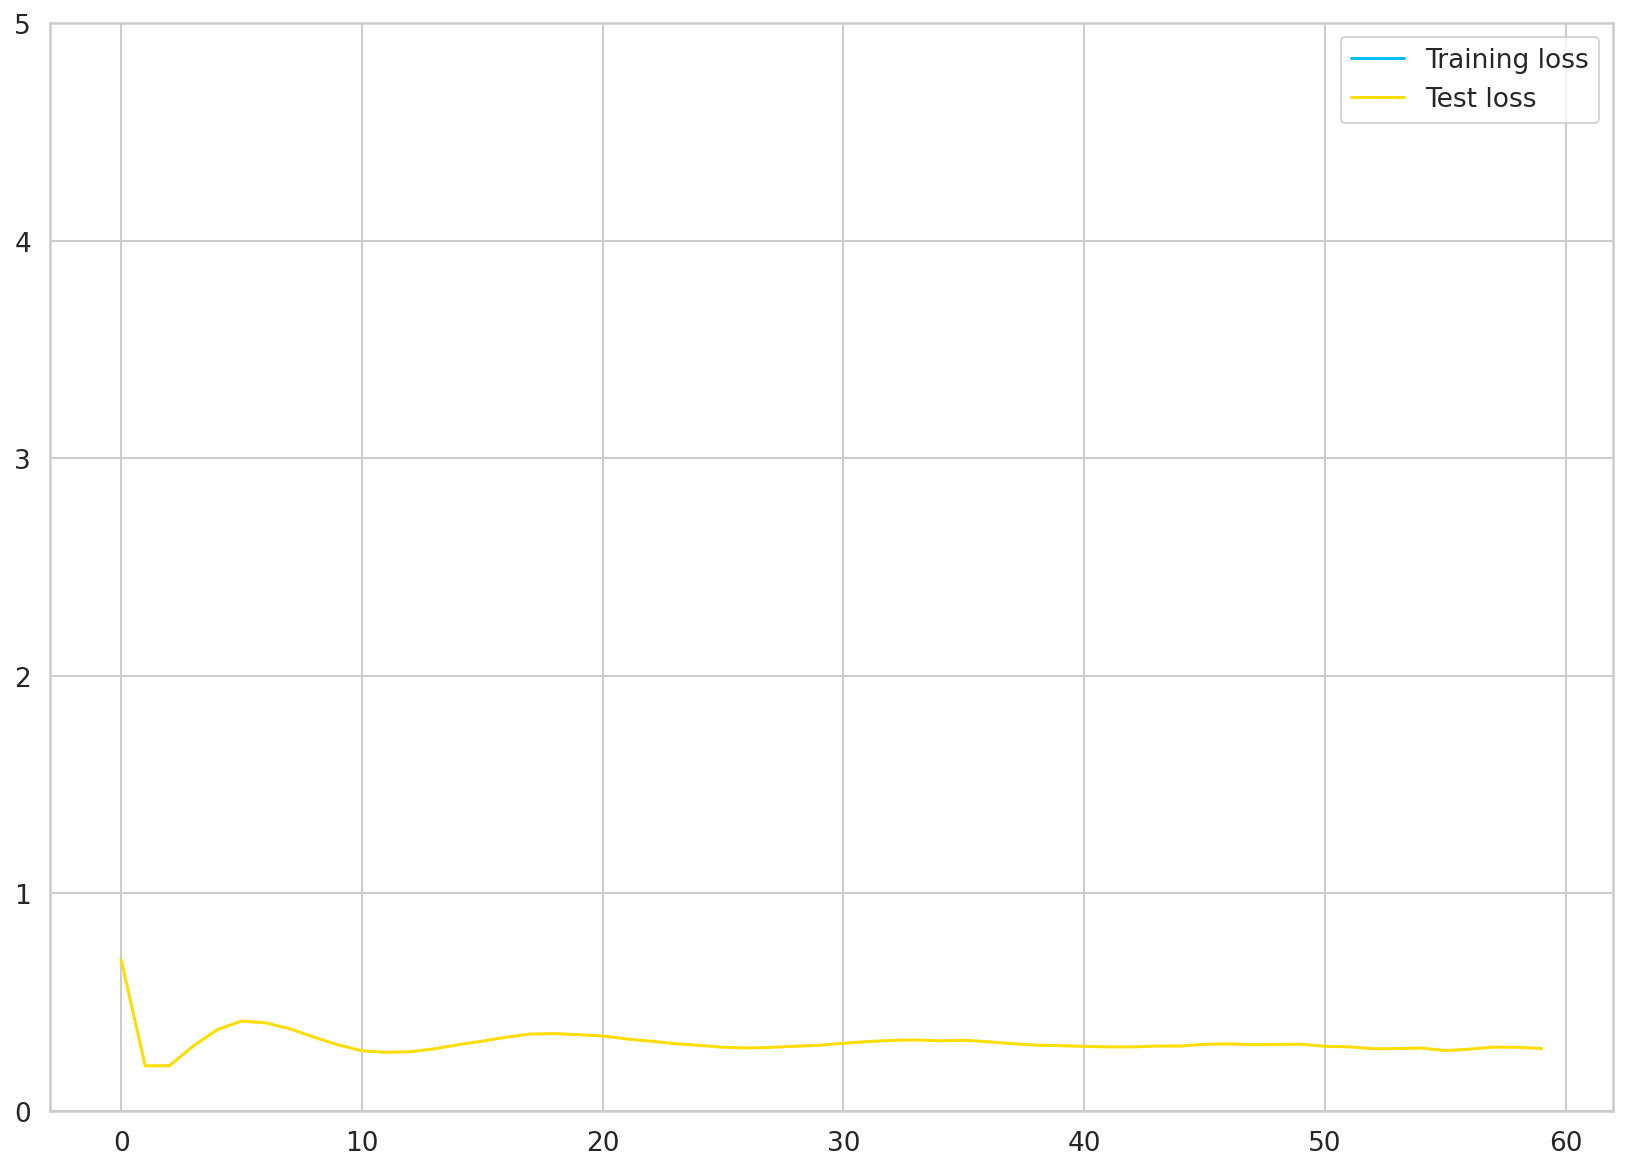

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

## 4.5 예측

### 4.5.1 일일 예측

In [ ]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

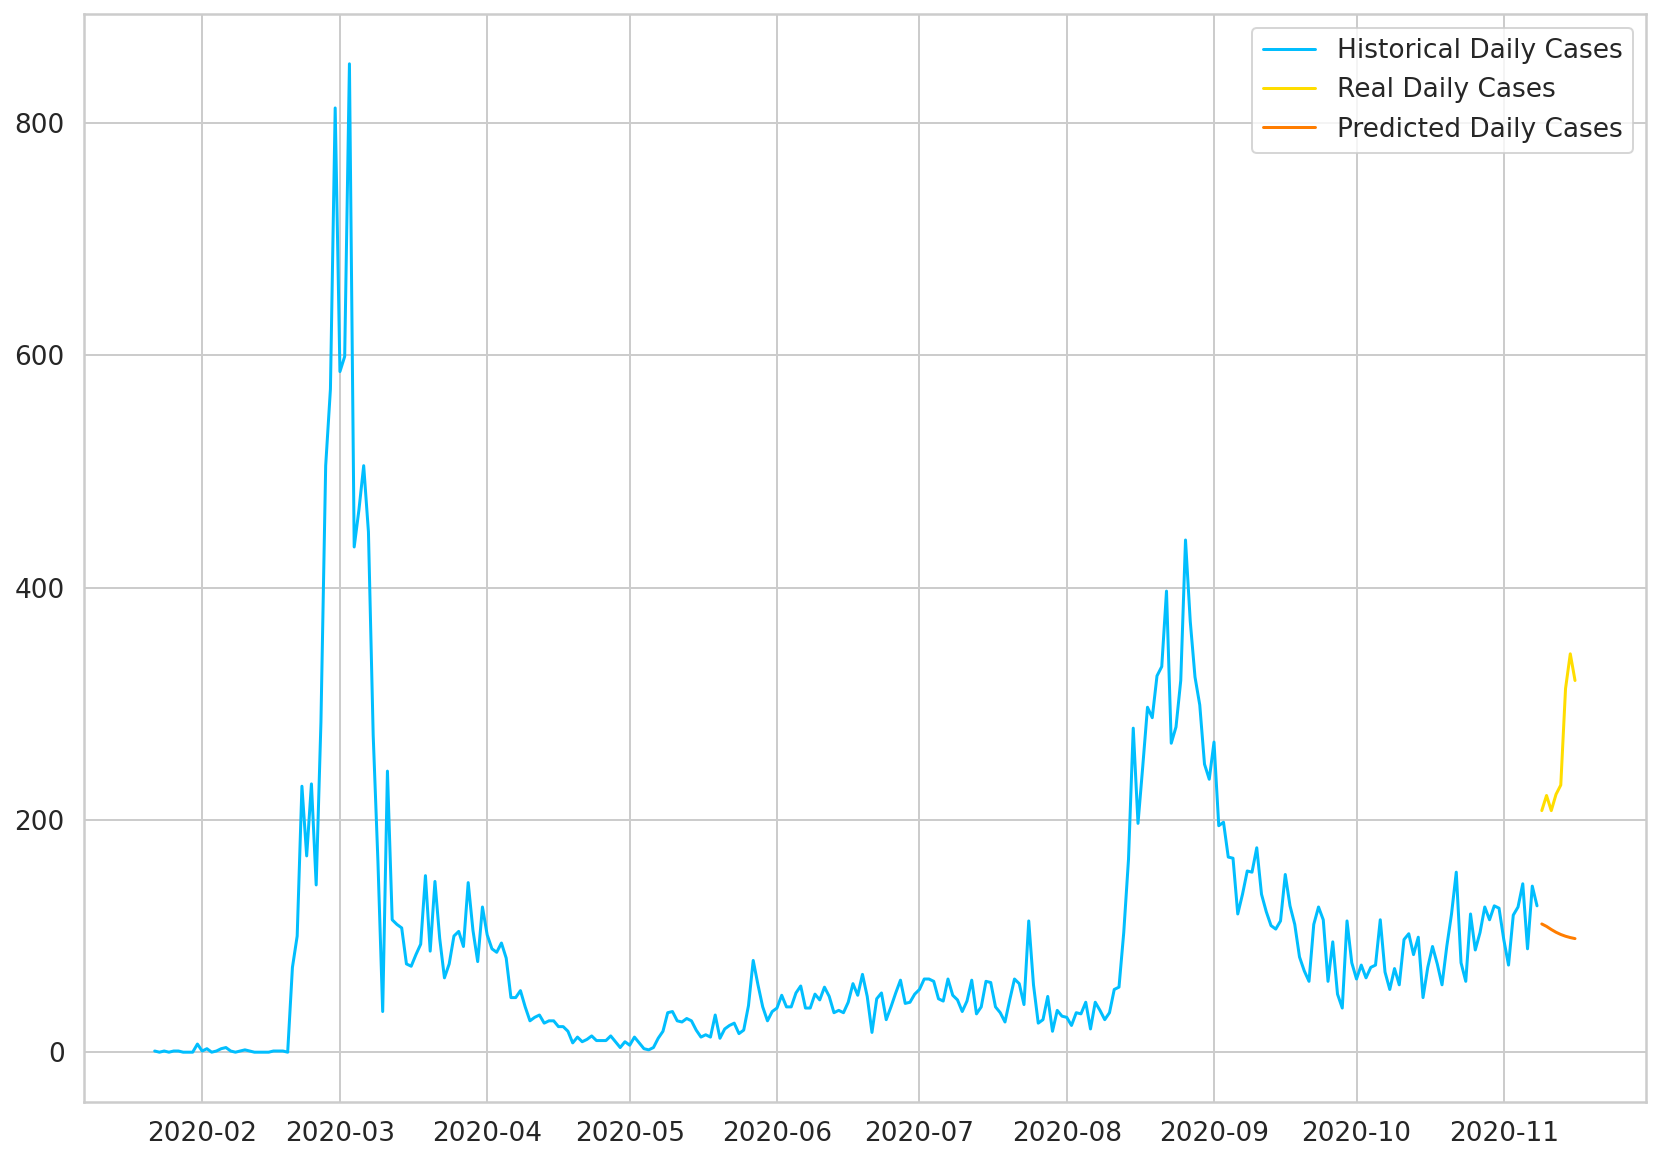

In [ ]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)
plt.legend();

### 4.5.2 전체 데이터셋 사용한 미래 예측

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(306, 1)

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 10.848782539367676
Epoch 10 train loss: 5.964972019195557
Epoch 20 train loss: 6.048274993896484
Epoch 30 train loss: 5.947442531585693
Epoch 40 train loss: 5.9559173583984375
Epoch 50 train loss: 5.936783790588379


In [ ]:
DAYS_TO_PREDICT = 12
with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
daily_cases.index[-1]

Timestamp('2020-11-22 00:00:00')

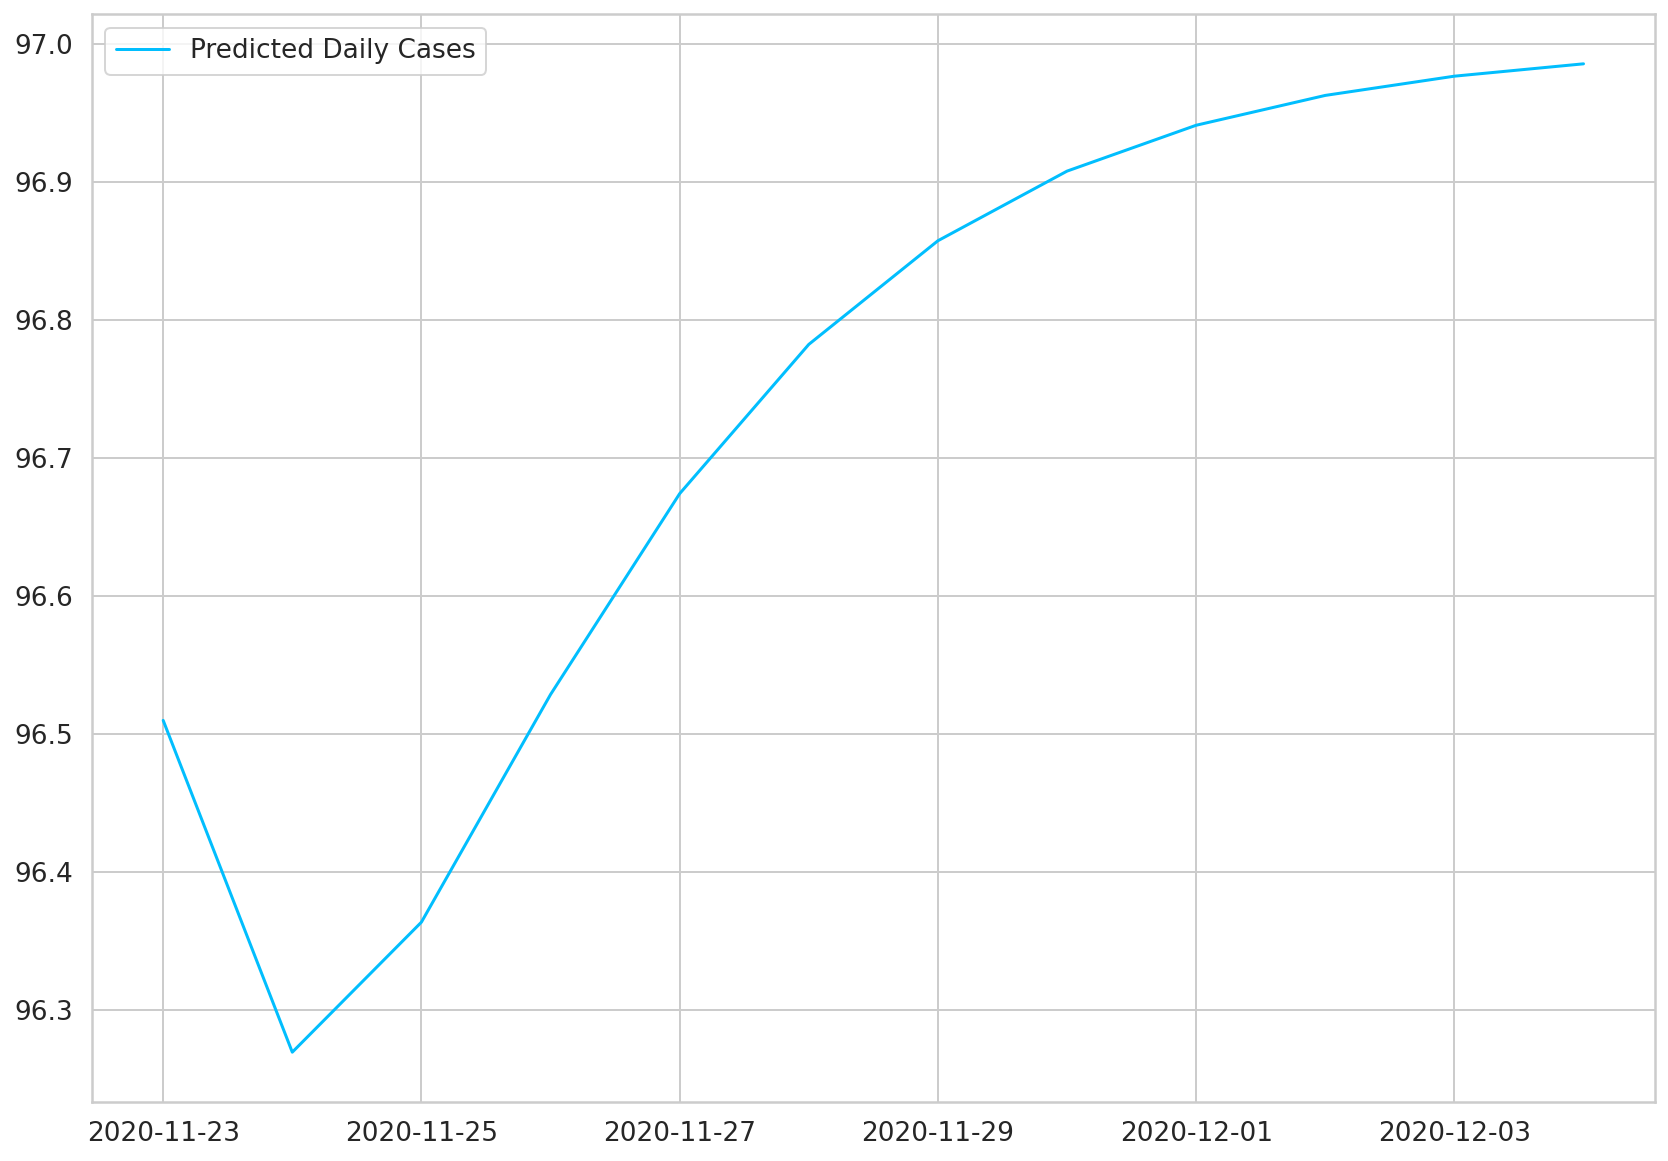

In [ ]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

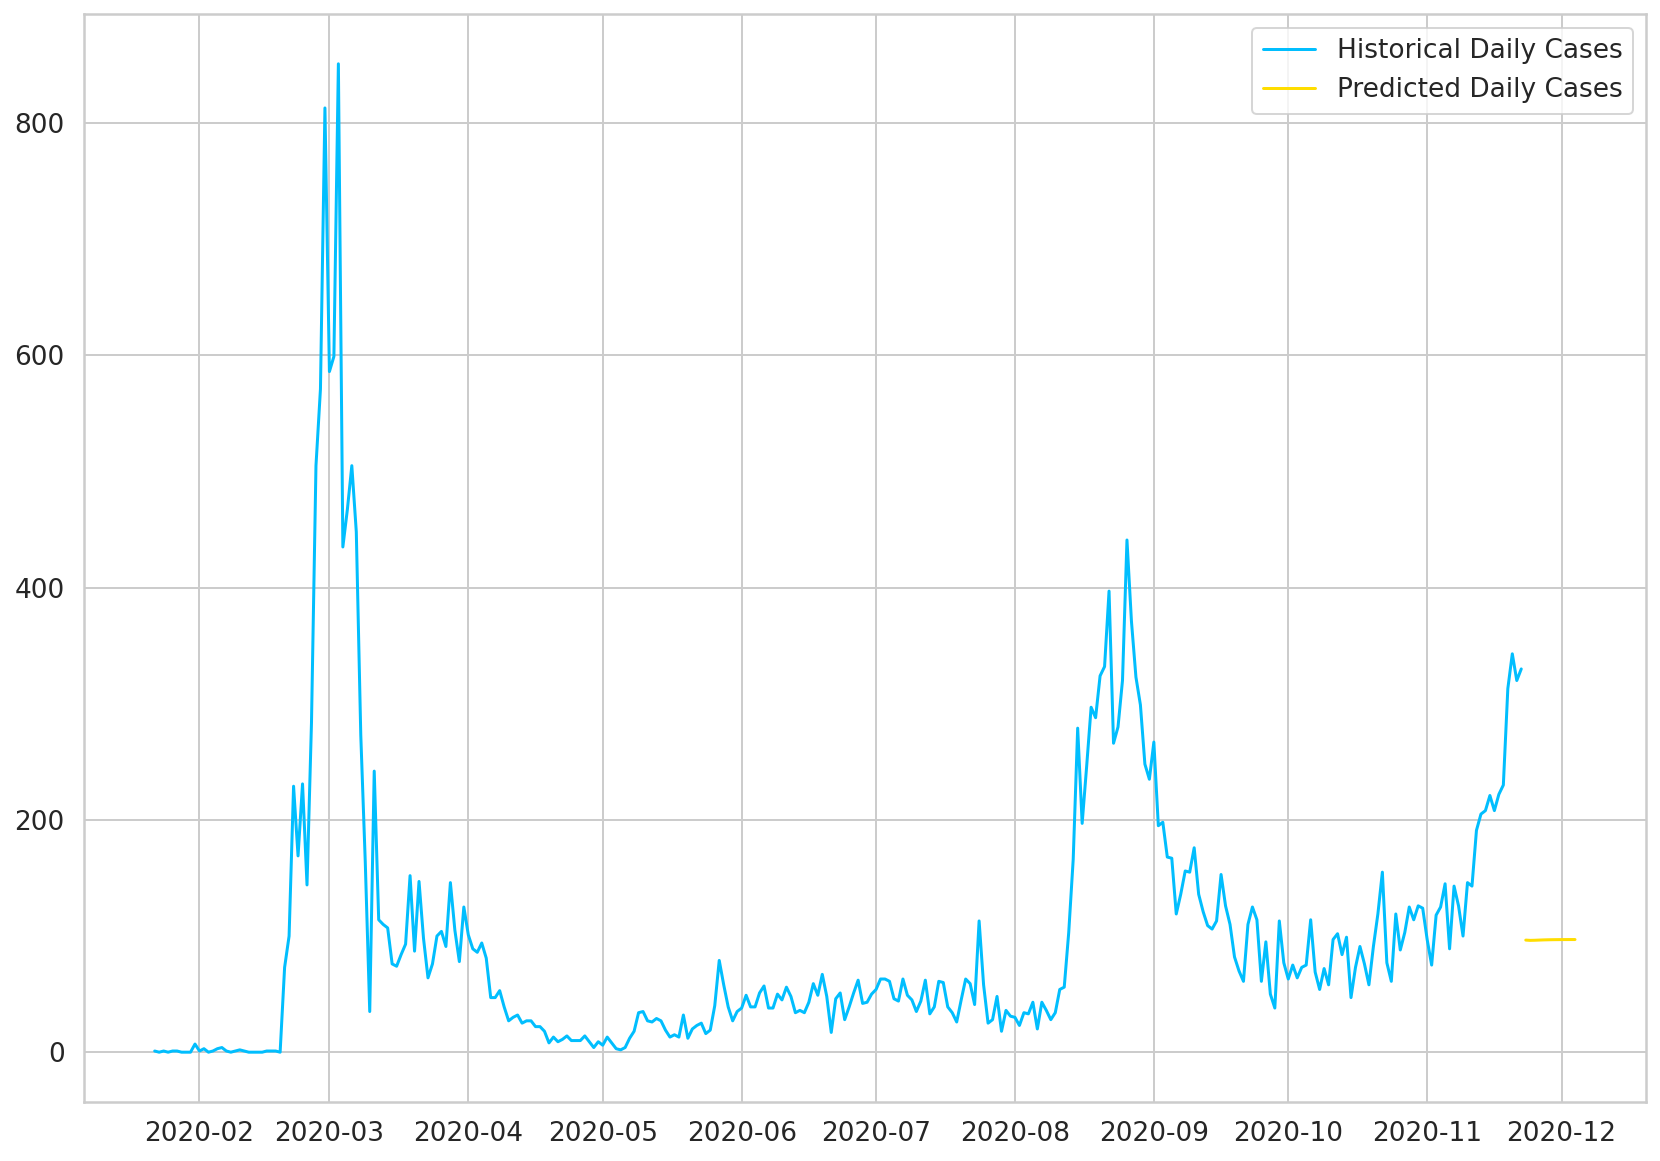

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();